# Install Dependencies

In [82]:
!pip install --upgrade transformers

# Import Libraries

In [2]:
import torch
import os
from tqdm import tqdm
import json

# evaluation imports
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
from transformers import logging
logging.set_verbosity_error()

# Device Validation

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


# Upload files and Path Validation

In [5]:
source_path = './'

In [6]:
files_list = os.listdir(source_path)

# Print the list of files
print("List of files in the specified path:")
for file_name in files_list:
    print(file_name)

List of files in the specified path:
.config
tokenizer.json
config.json
tokenizer_config.json
model.safetensors
dev-v2.0.json
train-v2.0.json
vocab.txt
special_tokens_map.json
.ipynb_checkpoints
sample_data


In [7]:
if not os.path.exists(source_path):
    os.mkdir(source_path)

# SQUAD Dataset

In [8]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

File ‘train-v2.0.json’ already there; not retrieving.

File ‘dev-v2.0.json’ already there; not retrieving.



# Load Model for Validation

In [9]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

def save_model(path, model, tokenizer):
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

def load_model(path, device=None):
    model = AutoModelForQuestionAnswering.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using {device}')

    model = model.to(device)
    return model, tokenizer

In [11]:
model, tokenizer = load_model(source_path)
model1 = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model2 = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")

Using cuda


config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model1.to(device)
model2.to(device)


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [12]:
from torch.utils.data import DataLoader

def model_accuracy(model, test_dataset, batch_size):
    start_accuracies, end_accuracies, batch_accuracies = [], [], []
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            attention_mask = batch['attention_mask'].to(device)
            input_ids = batch['input_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            start_positions_true = batch['answer_start_tokens'].to(device)
            end_positions_true = batch['answer_end_tokens'].to(device)

            start_positions_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_positions_pred = torch.argmax(outputs['end_logits'], dim=1)

            start_accuracy = (start_positions_pred == start_positions_true).sum()
            start_accuracy = start_accuracy / len(start_positions_pred)
            start_accuracy = start_accuracy.item()
            start_accuracies.append(start_accuracy)

            end_accuracy = (end_positions_pred == end_positions_true).sum()
            end_accuracy = end_accuracy / len(end_positions_pred)
            end_accuracy = end_accuracy.item()
            end_accuracies.append(end_accuracy)

            batch_accuracies.append(start_accuracy)
            batch_accuracies.append(end_accuracy)

    start_accuracy = sum(start_accuracies) / len(start_accuracies)
    end_accuracy = sum(end_accuracies) / len(end_accuracies)
    accuracy = sum(batch_accuracies) / len(batch_accuracies)

    return start_accuracy, end_accuracy, accuracy

In [13]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        super().__init__()
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [14]:
tokenizer = AutoTokenizer.from_pretrained('./')

In [15]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        dataset = json.load(f)

    contexts, questions, answers = [], [], []

    for data in dataset['data']:
        for paragraph in data['paragraphs']:
            context = paragraph['context']
            for qas in paragraph['qas']:
                question = qas['question']
                for answer in qas['answers']:
                    text = answer['text']
                    answer_start = answer['answer_start']
                    answer['answer_end'] = answer_start + len(text)

                    # # SQuAD labels can be off by an index or two sometimes
                    # if context[answer_start:answer_end] == text:
                    #     answer['answer_end'] = answer_end
                    # elif context[answer_start-1:answer_end-1] == text:
                    #     answer['answer_start'] = answer_start - 1
                    #     answer['answer_end'] = answer_end - 1
                    # elif context[answer_start-2:answer_end-2] == text:
                    #     answer['answer_start'] = answer_start - 2
                    #     answer['answer_end'] = answer_end - 2

                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

In [16]:
# If loading SQuAD instead of downloading, change paths here
train_path, test_path = 'train-v2.0.json', 'dev-v2.0.json'
train_contexts, train_questions, train_answers = load_data(train_path)
test_contexts, test_questions, test_answers = load_data(test_path)

In [17]:
train_encodings = tokenizer(train_contexts,
                            train_questions,
                            truncation=True,
                            padding=True)

test_encodings = tokenizer(test_contexts,
                           test_questions,
                           truncation=True,
                           padding=True)

In [18]:
def answers_char_to_token(answers, encodings):
    answer_start_tokens, answer_end_tokens = [], []
    for i in range(len(answers)):
        start_token = encodings.char_to_token(i, answers[i]['answer_start'])
        end_token = encodings.char_to_token(i, answers[i]['answer_end'] - 1)

        answer_start_tokens.append(start_token)
        answer_end_tokens.append(end_token)

        # Check for truncated answer passages
        if answer_start_tokens[-1] is None:
            answer_start_tokens[-1] = tokenizer.model_max_length
        if answer_end_tokens[-1] is None:
            answer_end_tokens[-1] = tokenizer.model_max_length

    encodings.update({'answer_start_tokens': answer_start_tokens,
                      'answer_end_tokens': answer_end_tokens})

In [19]:
answers_char_to_token(train_answers, train_encodings)
answers_char_to_token(test_answers, test_encodings)

In [20]:
train_dataset = Custom_Dataset(train_encodings)
test_dataset = Custom_Dataset(test_encodings)

In [21]:
hyperparameters = {}
hyperparameters['N_EPOCHS'] = 5
hyperparameters['learning_rate'] = 5e-5
hyperparameters['weight_decay'] = 0.01
hyperparameters['batch_size'] = 16

In [22]:
start_accuracy, end_accuracy, accuracy = model_accuracy(model,
                                                        test_dataset,
                                                        hyperparameters['batch_size'])

print()
print(f'Start Accuracy: {start_accuracy}')
print(f'End Accuracy: {end_accuracy}')
print(f'Accuracy: {accuracy}')

  9%|▊         | 110/1269 [00:32<05:38,  3.42it/s]


KeyboardInterrupt: ignored

In [26]:
def calculate_f1_scores(true_starts, true_ends, pred_starts, pred_ends):
    f1_scores = []
    for true_start, true_end, pred_start, pred_end in zip(true_starts, true_ends, pred_starts, pred_ends):
        common_tokens = len(set(range(true_start, true_end + 1)) & set(range(pred_start, pred_end + 1)))
        if common_tokens == 0:
            f1_scores.append(0)
            continue
        precision = common_tokens / (pred_end - pred_start + 1)
        recall = common_tokens / (true_end - true_start + 1)
        f1_scores.append(2 * (precision * recall) / (precision + recall))
    return np.mean(f1_scores)


In [23]:
from tqdm import tqdm

def evaluate_model(model, test_dataset, batch_size):
    model.eval()
    all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = [], [], [], []

    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            start_time = time.time()

            # Forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            # Measure latency
            latency = time.time() - start_time
            all_latencies.append(latency)

            # True positions
            start_positions_true = batch['answer_start_tokens'].to(device)
            end_positions_true = batch['answer_end_tokens'].to(device)

            # Predicted positions
            start_positions_pred = torch.argmax(outputs.start_logits, dim=1)
            end_positions_pred = torch.argmax(outputs.end_logits, dim=1)

            # Calculate accuracies
            start_accuracy = torch.mean((start_positions_pred == start_positions_true).float()).item()
            end_accuracy = torch.mean((end_positions_pred == end_positions_true).float()).item()
            all_start_accuracies.append(start_accuracy)
            all_end_accuracies.append(end_accuracy)

            # Calculate F1 scores
            f1_score_batch = calculate_f1_scores(start_positions_true.tolist(),
                                                 end_positions_true.tolist(),
                                                 start_positions_pred.tolist(),
                                                 end_positions_pred.tolist())
            all_f1_scores.append(f1_score_batch)

    # Aggregate results
    final_start_accuracy = np.mean(all_start_accuracies)
    final_end_accuracy = np.mean(all_end_accuracies)
    final_f1_score = np.mean(all_f1_scores)
    average_latency = np.mean(all_latencies)

    return final_start_accuracy, final_end_accuracy, final_f1_score, average_latency


In [31]:
start_accuracy, end_accuracy, f1_score, avg_latency = evaluate_model(model, test_dataset, hyperparameters['batch_size'])
print(f'Start Accuracy: {start_accuracy}\nEnd Accuracy: {end_accuracy}\nF1 Score: {f1_score}\nAverage Latency: {avg_latency} seconds')


Evaluating: 100%|██████████| 1269/1269 [05:37<00:00,  3.76batch/s]

Start Accuracy: 0.620637735012857
End Accuracy: 0.6680738489349777
F1 Score: 0.7021432049462872
Average Latency: 0.009411442270421719 seconds


In [30]:
start_accuracy1, end_accuracy1, f1_score1, avg_latency1 = evaluate_model(model1, test_dataset, hyperparameters['batch_size'])
print(f'Start Accuracy: {start_accuracy1}\nEnd Accuracy: {end_accuracy1}\nF1 Score: {f1_score1}\nAverage Latency: {avg_latency1} seconds')


Evaluating: 100%|██████████| 1269/1269 [05:41<00:00,  3.72batch/s]

Start Accuracy: 0.004137115839243499
End Accuracy: 0.0037431048069345944
F1 Score: 0.016567086930893513
Average Latency: 0.011713866646408189 seconds


In [32]:
start_accuracy2, end_accuracy2, f1_score2, avg_latency2 = evaluate_model(model2, test_dataset, hyperparameters['batch_size'])
print(f'Start Accuracy: {start_accuracy2}\nEnd Accuracy: {end_accuracy2}\nF1 Score: {f1_score2}\nAverage Latency: {avg_latency2} seconds')


Evaluating: 100%|██████████| 1269/1269 [05:35<00:00,  3.78batch/s]

Start Accuracy: 0.12674490601364508
End Accuracy: 0.1322399527186761
F1 Score: 0.12518695315780212
Average Latency: 0.009232584560265026 seconds


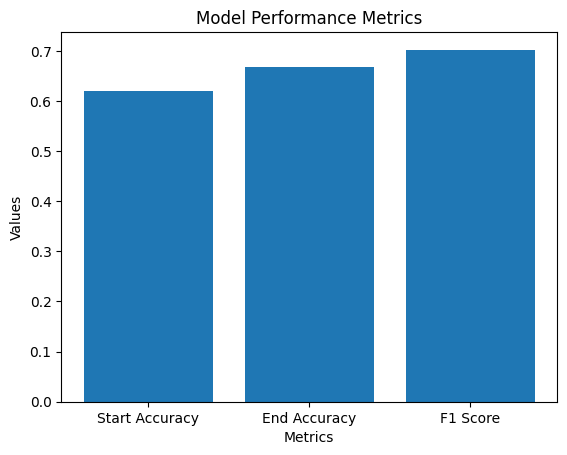

In [33]:
import matplotlib.pyplot as plt

# Example of plotting accuracy and F1 score
metrics = [start_accuracy, end_accuracy, f1_score]
labels = ['Start Accuracy', 'End Accuracy', 'F1 Score']

plt.bar(labels, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics')
plt.show()


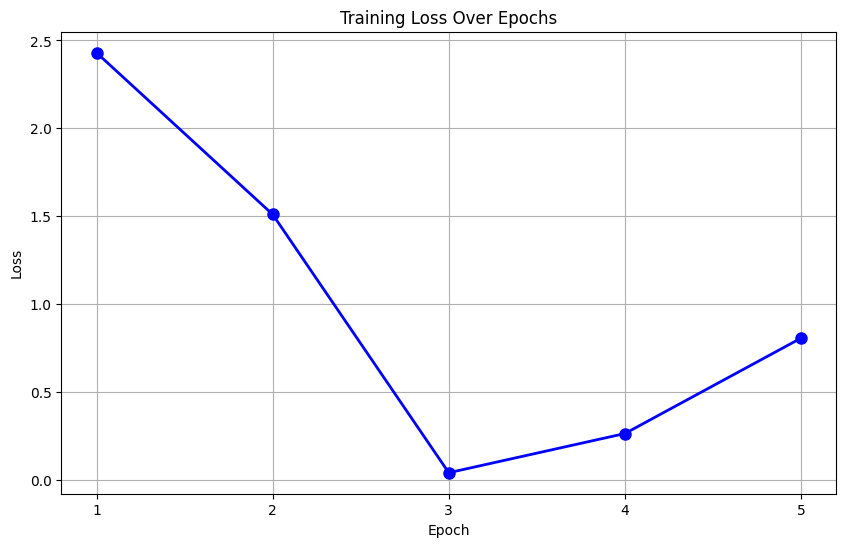

In [34]:
import matplotlib.pyplot as plt

# Data: Training loss values for each epoch
epochs = [1, 2, 3, 4, 5]
losses = [2.43, 1.51, 0.04, 0.263, 0.806]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()



In [28]:
import json
import random

def get_random_sample(file_path):
    with open(file_path, 'r') as file:
        squad_data = json.load(file)

    while True:
        # Select a random article
        article = random.choice(squad_data['data'])

        # Select a random paragraph from the article
        paragraph = random.choice(article['paragraphs'])

        # Select a random question-answer pair from the paragraph
        qa_pair = random.choice(paragraph['qas'])

        # Check if the answer exists
        if qa_pair['answers']:
            context = paragraph['context']
            question = qa_pair['question']
            answer = qa_pair['answers'][0]['text']  # Assuming we take the first answer
            return context, question, answer

# Specify the path to your SQuAD dataset file
file_path = 'train-v2.0.json'  # or 'dev-v2.0.json'

# Get a random sample
context, question, answer = get_random_sample(file_path)

print("Context:", context)
print("Question:", question)
print("Answer:", answer)


Context: The Central African Republic (CAR; Sango: Ködörösêse tî Bêafrîka; French: République centrafricaine  pronounced: [ʁepyblik sɑ̃tʁafʁikɛn], or Centrafrique [sɑ̃tʀafʁik]) is a landlocked country in Central Africa. It is bordered by Chad to the north, Sudan to the northeast, South Sudan to the east, the Democratic Republic of the Congo and the Republic of the Congo to the south and Cameroon to the west. The CAR covers a land area of about 620,000 square kilometres (240,000 sq mi) and had an estimated population of around 4.7 million as of 2014[update].
Question: What Country borders CAR in the West?
Answer: Cameroon


In [29]:
def predict_answer(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

# Example context and question
context, question, answer = get_random_sample(file_path)


# Predict the answer
pred_answer = predict_answer(context, question)
print("Context:", context)
print("Question:", question)
print("Actual Answer:", answer)
print("Predicted Answer:", pred_answer)

Context: Evidence of Anatomically modern humans in the Indian subcontinent is recorded as long as 75,000 years ago, or with earlier hominids including Homo erectus from about 500,000 years ago. The Indus Valley Civilization which spread and flourished in the northwestern part of the Indian subcontinent from c. 3200 to 1300 BCE, was the first major civilization in South Asia. A sophisticated and technologically advanced urban culture developed in the Mature Harappan period, from 2600 to 1900 BCE. This civilization collapsed at the start of the second millennium BCE and was later followed by the Iron Age Vedic Civilization, which extended over much of the Indo-Gangetic plain and which witnessed the rise of major polities known as the Mahajanapadas. In one of these kingdoms, Magadha, Mahavira and Gautama Buddha propagated their Shramanic philosophies during the fifth and sixth century BCE.
Question: For how long have modern humans lived on the Indian subcontinent?
Actual Answer: 75,000 ye

Evaluating: 100%|██████████| 1269/1269 [05:36<00:00,  3.77batch/s]


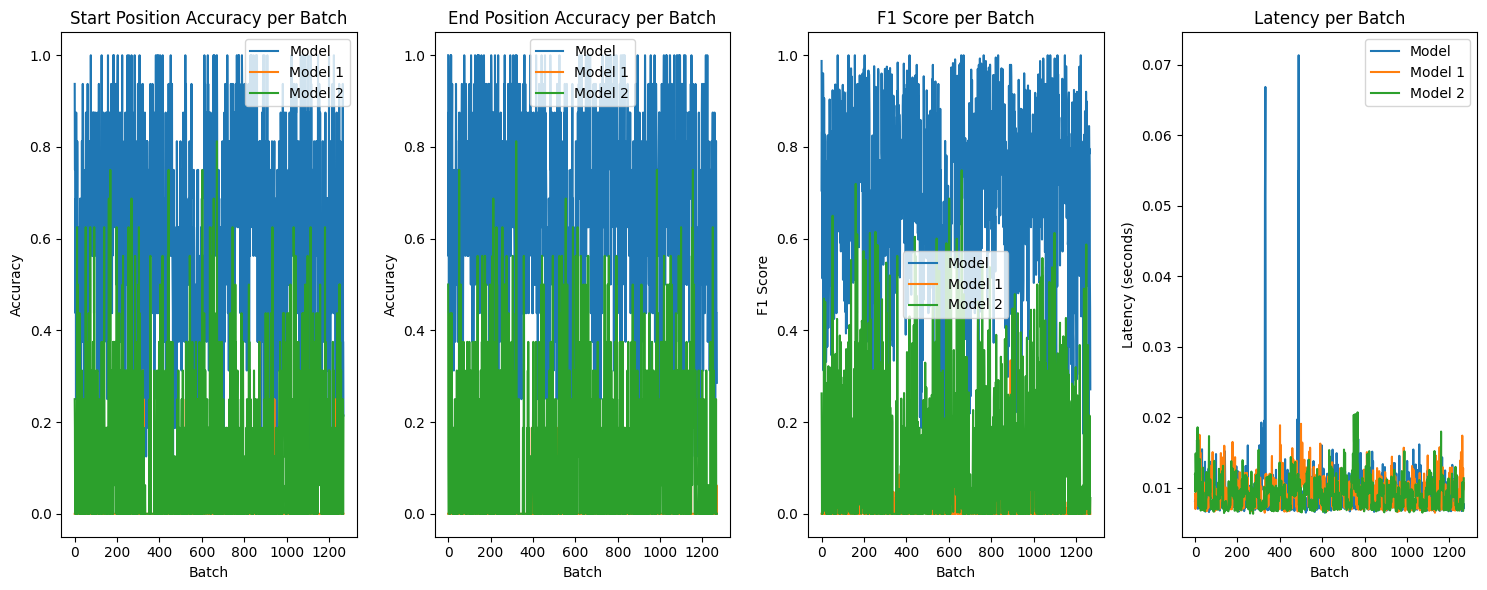

In [35]:


def evaluate_model(model, test_dataset, batch_size):
    model.eval()
    all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = [], [], [], []

    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            start_time = time.time()

            # Forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            # Measure latency
            latency = time.time() - start_time
            all_latencies.append(latency)

            # True positions
            start_positions_true = batch['answer_start_tokens'].to(device)
            end_positions_true = batch['answer_end_tokens'].to(device)

            # Predicted positions
            start_positions_pred = torch.argmax(outputs.start_logits, dim=1)
            end_positions_pred = torch.argmax(outputs.end_logits, dim=1)

            # Calculate accuracies
            start_accuracy = torch.mean((start_positions_pred == start_positions_true).float()).item()
            end_accuracy = torch.mean((end_positions_pred == end_positions_true).float()).item()
            all_start_accuracies.append(start_accuracy)
            all_end_accuracies.append(end_accuracy)

            # Calculate F1 scores
            f1_score_batch = calculate_f1_scores(start_positions_true.tolist(),
                                                 end_positions_true.tolist(),
                                                 start_positions_pred.tolist(),
                                                 end_positions_pred.tolist())
            all_f1_scores.append(f1_score_batch)

    return all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies

# Evaluate the model
all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = evaluate_model(model, test_dataset, batch_size=16)
all_start_accuracies1, all_end_accuracies1, all_f1_scores1, all_latencies1 = evaluate_model(model1, test_dataset, batch_size=16)
all_start_accuracies2, all_end_accuracies2, all_f1_scores2, all_latencies2 = evaluate_model(model2, test_dataset, batch_size=16)

# Plotting the metrics over batches
plt.figure(figsize=(15, 6))

# Start Position Accuracy
plt.subplot(1, 4, 1)
plt.plot(all_start_accuracies, label='Model')
plt.plot(all_start_accuracies1, label='Model 1')
plt.plot(all_start_accuracies2, label='Model 2')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Start Position Accuracy per Batch')
plt.legend()

# End Position Accuracy
plt.subplot(1, 4, 2)
plt.plot(all_end_accuracies, label='Model')
plt.plot(all_end_accuracies1, label='Model 1')
plt.plot(all_end_accuracies2, label='Model 2')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('End Position Accuracy per Batch')
plt.legend()

# F1 Score
plt.subplot(1, 4, 3)
plt.plot(all_f1_scores, label='Model')
plt.plot(all_f1_scores1, label='Model 1')
plt.plot(all_f1_scores2, label='Model 2')
plt.xlabel('Batch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Batch')
plt.legend()

# Latency
plt.subplot(1, 4, 4)
plt.plot(all_latencies, label='Model')
plt.plot(all_latencies1, label='Model 1')
plt.plot(all_latencies2, label='Model 2')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = evaluate_model(model, test_dataset, batch_size=256)
all_start_accuracies1, all_end_accuracies1, all_f1_scores1, all_latencies1 = evaluate_model(model1, test_dataset, batch_size=256)
all_start_accuracies2, all_end_accuracies2, all_f1_scores2, all_latencies2 = evaluate_model(model2, test_dataset, batch_size=256)

Evaluating: 100%|██████████| 80/80 [05:22<00:00,  4.03s/batch]


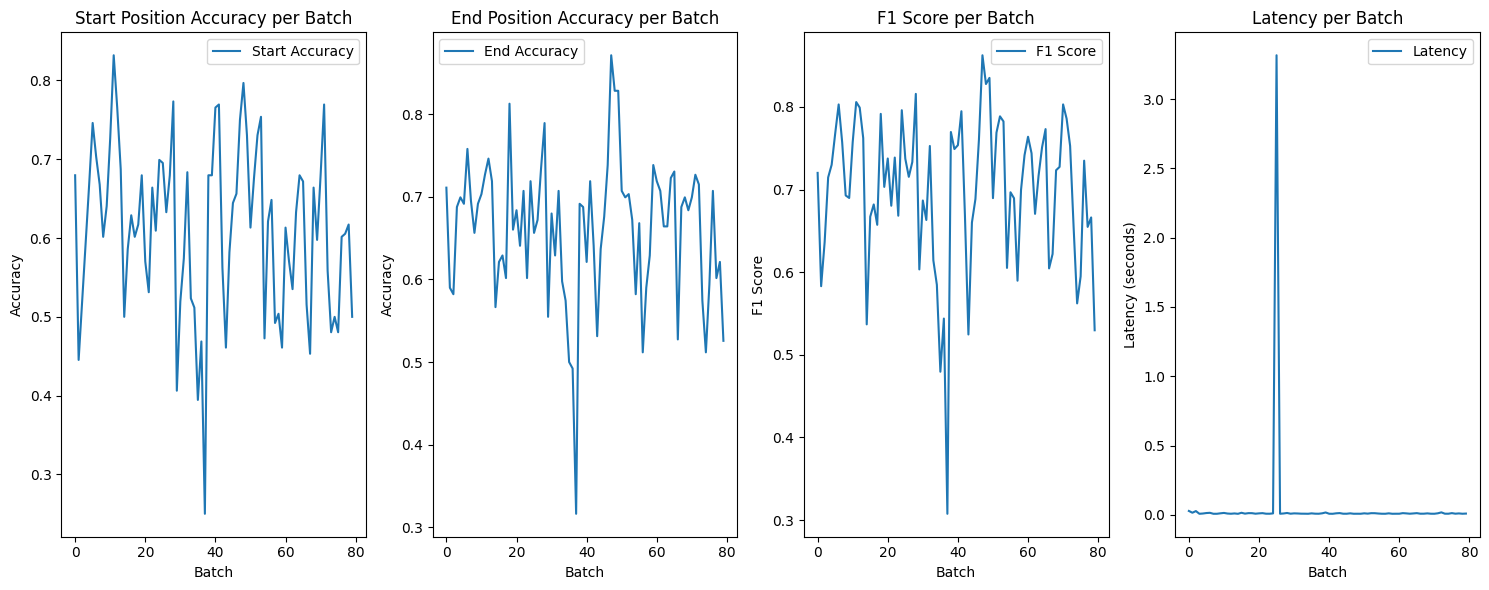

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.plot(all_start_accuracies, label='Start Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Start Position Accuracy per Batch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(all_end_accuracies, label='End Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('End Position Accuracy per Batch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(all_f1_scores, label='F1 Score')
plt.xlabel('Batch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Batch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(all_latencies, label='Latency')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()

plt.tight_layout()
plt.show()

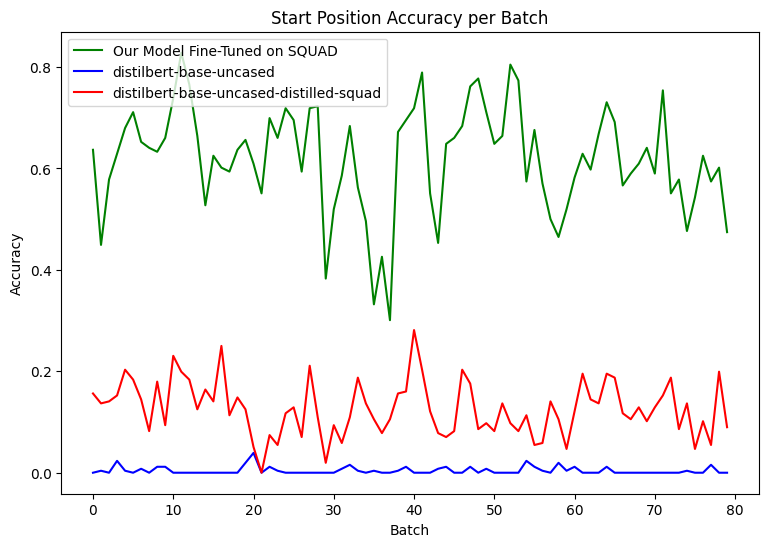

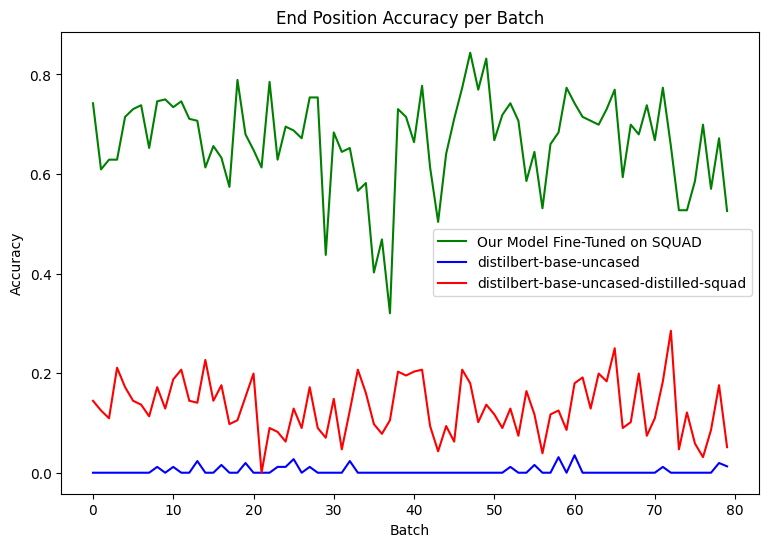

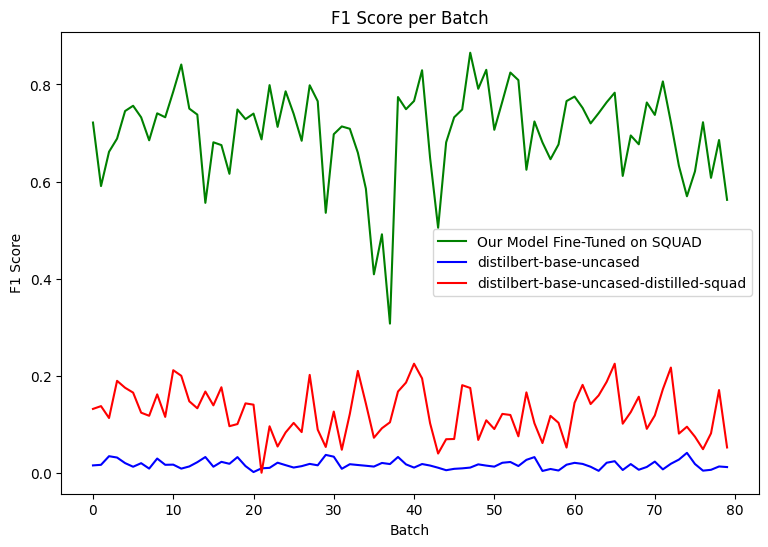

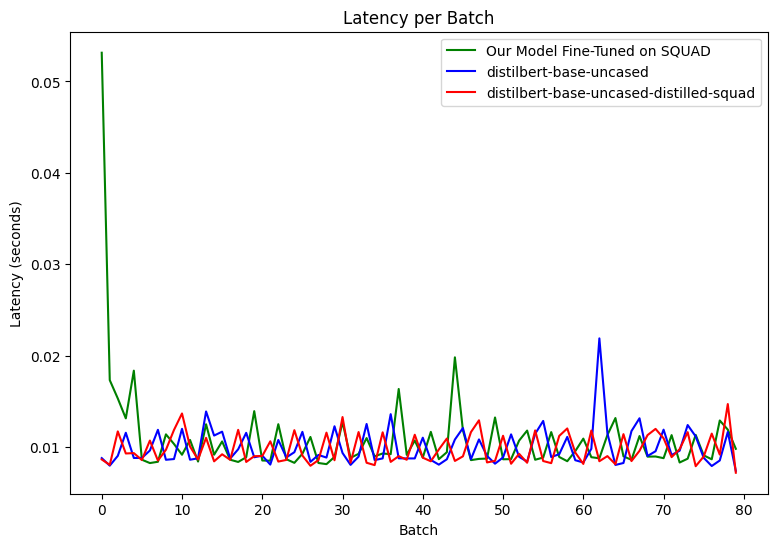

In [44]:
# Plotting each metric in separate figures

# Plotting Start Accuracy
plt.figure(figsize=(9, 6))
plt.plot(all_start_accuracies, label='Our Model Fine-Tuned on SQUAD', color='green')
plt.plot(all_start_accuracies1, label='distilbert-base-uncased', color='blue')
plt.plot(all_start_accuracies2, label='distilbert-base-uncased-distilled-squad', color='red')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Start Position Accuracy per Batch')
plt.legend()
plt.show()

# Plotting End Accuracy
plt.figure(figsize=(9, 6))
plt.plot(all_end_accuracies, label='Our Model Fine-Tuned on SQUAD', color='green')
plt.plot(all_end_accuracies1, label='distilbert-base-uncased', color='blue')
plt.plot(all_end_accuracies2, label='distilbert-base-uncased-distilled-squad', color='red')
# plt.plot(all_end_accuracies, label='End Accuracy', color='green')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('End Position Accuracy per Batch')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(9, 6))
plt.plot(all_f1_scores, label='Our Model Fine-Tuned on SQUAD', color='green')
plt.plot(all_f1_scores1, label='distilbert-base-uncased', color='blue')
plt.plot(all_f1_scores2, label='distilbert-base-uncased-distilled-squad', color='red')
# plt.plot(all_f1_scores, label='F1 Score', color='red')
plt.xlabel('Batch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Batch')
plt.legend()
plt.show()

# Plotting Latency
plt.figure(figsize=(9, 6))
plt.plot(all_latencies, label='Our Model Fine-Tuned on SQUAD', color='green')
plt.plot(all_latencies1, label='distilbert-base-uncased', color='blue')
plt.plot(all_latencies2, label='distilbert-base-uncased-distilled-squad', color='red')
# plt.plot(all_latencies, label='Latency', color='purple')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()
plt.show()



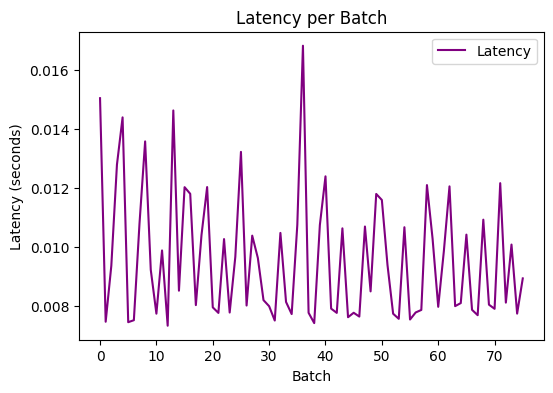

In [ ]:
filtered_latencies = [lat for lat in all_latencies if lat < np.percentile(all_latencies, 95)]

# Plotting Latency without the outlier
plt.figure(figsize=(6, 4))
plt.plot(filtered_latencies, label='Latency', color='purple')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()
plt.show()

In [ ]:
def load_squad_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

squad_train_dataset = load_squad_dataset('train-v2.0.json')


In [ ]:
def plot_length_distribution(data):
    context_lengths = []
    question_lengths = []
    answer_lengths = []

    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            context_lengths.append(len(context.split()))  # Tokenize context and count words

            for qa in paragraph['qas']:
                question = qa['question']
                question_lengths.append(len(question.split()))  # Tokenize question and count words

                # Add answer lengths if answers are available
                for answer in qa.get('answers', []):
                    answer_lengths.append(len(answer['text'].split()))

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(context_lengths, bins=50, color='blue', edgecolor='black')
    plt.title('Distribution of Context Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(question_lengths, bins=50, color='green', edgecolor='black')
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(answer_lengths, bins=50, color='red', edgecolor='black')
    plt.title('Distribution of Answer Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

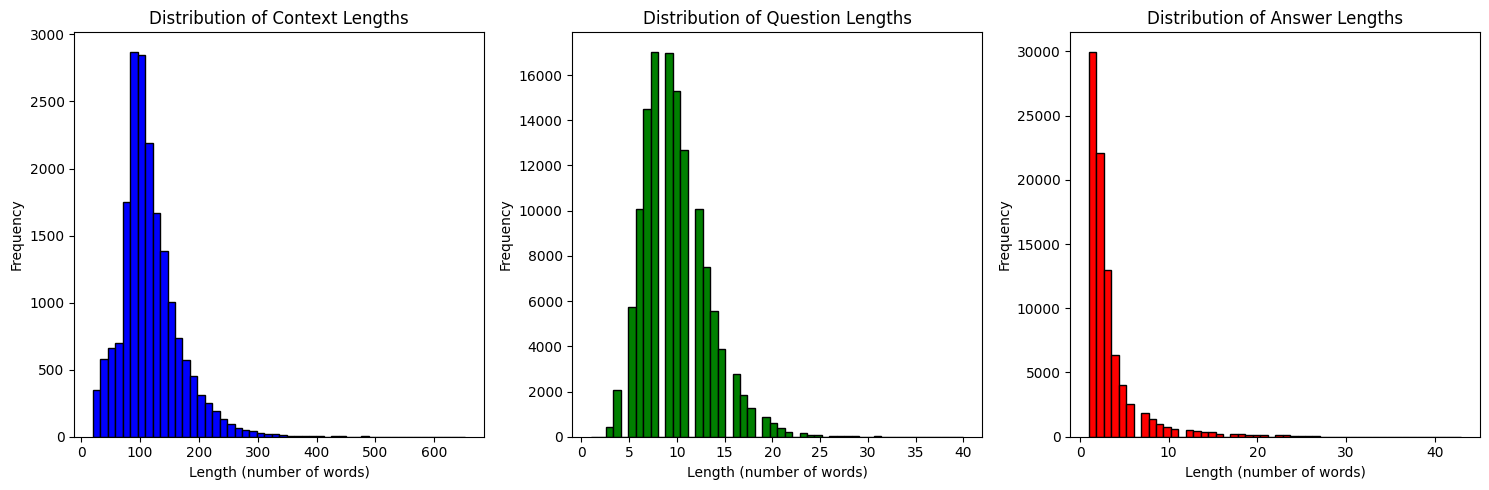

In [ ]:
plot_length_distribution(squad_train_dataset)

In [ ]:
print(model)

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [76]:
def test_robustness(model, tokenizer, queries, contexts):
    model.eval()
    results = []
    for query, context in zip(queries, contexts):
        inputs = tokenizer.encode_plus(query, context, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        answer_start = torch.argmax(outputs.start_logits)
        answer_end = torch.argmax(outputs.end_logits) + 1
        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
        results.append((query, answer))
    return results

# Example usage
ambiguous_queries = [
    "Who led the expedition?",
    "What is the capital of Australia?",
    "When was the treaty signed?",
    "What causes the disease?",
    "Who wrote Hamlet?",
    "What is the tallest mountain?",
    "What is the heart of the city?"
]

contexts = [
    "In 1804, Meriwether Lewis and William Clark led an expedition to explore the newly acquired western portion of the United States after the Louisiana Purchase. Meanwhile, in the same year, Napoleon Bonaparte declared himself the emperor of France.",
    "Sydney is the largest city in Australia and is often mistaken for the capital. However, the actual capital of Australia is Canberra.",
    "The treaty, which ended the long-standing war, was signed after prolonged negotiations. The war had lasted for over a decade, with significant losses on both sides.",
    "The disease, known as Parkinson's, is often confused with Alzheimer's due to similar symptoms. However, Parkinson's is primarily caused by the loss of dopamine-producing cells in the brain.",
    "Hamlet, a famous play written by William Shakespeare, has been adapted into various films and books. Some of these adaptations were done by directors like Laurence Olivier and Kenneth Branagh.",
    "Mount Everest is often cited as the tallest mountain in the world. However, Mauna Kea in Hawaii is technically the tallest when measured from its base underwater.",
    "The city is known for its vibrant central district, often referred to as the heart of the city, which includes both the historical town square and the main business district."
]

robustness_results = test_robustness(model, tokenizer, ambiguous_queries, contexts)



In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_performance(predictions, references):
    # Filter out None values and ensure text format is consistent
    filtered_data = [(pred.lower(), ref.lower()) for pred, ref in zip(predictions, references) if ref is not None]

    # Unpack predictions and references
    if not filtered_data:
        return 0, 0, 0, 0  # Return zero scores if no data is available

    filtered_predictions, filtered_references = zip(*filtered_data)

    # Calculate performance metrics
    accuracy = accuracy_score(filtered_references, filtered_predictions)
    precision = precision_score(filtered_references, filtered_predictions, average='weighted')
    recall = recall_score(filtered_references, filtered_predictions, average='weighted')
    f1 = f1_score(filtered_references, filtered_predictions, average='weighted')

    return accuracy, precision, recall, f1

In [78]:
# Run the Robustness Test
robustness_results = test_robustness(model, tokenizer, ambiguous_queries, contexts)

# List of expected answers
expected_answers = [
    "Meriwether Lewis and William Clark",  # for "Who led the expedition?"
    "Canberra",                            # for "What is the capital of Australia?"
    None,                                  # for "When was the treaty signed?" (ambiguous)
    "loss of dopamine-producing cells",    # for "What causes the disease?"
    "William Shakespeare",                 # for "Who wrote Hamlet?"
    "Mauna Kea",                           # for "What is the tallest mountain?" (interpretation dependent)
    None                                   # for "What is the heart of the city?" (subjective)
]

# Extract model predictions
model_predictions = [result[1] for result in robustness_results]

evaluable_answers = [(pred.lower(), exp.lower()) for pred, exp in zip(model_predictions, expected_answers) if exp is not None]

# Initialize an empty list to store binary scores for accuracy calculation
binary_scores = []
performance_scores = []
for pred, exp in evaluable_answers:
    binary_scores.append(int(pred == exp))  # Append 1 for correct, 0 for incorrect

# Now calculate the accuracy for each query
accuracy_per_query = [accuracy_score([ref], [pred]) for pred, ref in evaluable_answers]

# Append the accuracy scores to the performance_scores array
performance_scores.extend(accuracy_per_query)

# Additional step for subjective or ambiguous questions
for i in range(len(expected_answers)):
    if expected_answers[i] is None:
        performance_scores.insert(i, 0.5)  # Assuming subjective answers as partially correct


# Manual Review (for all queries)
for query, (context, model_answer) in zip(ambiguous_queries, robustness_results):
    print(f"Query: {query}\nContext: {context}\nModel Answer: {model_answer}\n")


Query: Who led the expedition?
Context: Who led the expedition?
Model Answer: meriwether lewis and william clark

Query: What is the capital of Australia?
Context: What is the capital of Australia?
Model Answer: canberra

Query: When was the treaty signed?
Context: When was the treaty signed?
Model Answer: prolonged negotiations. the war had lasted for over a decade, with significant losses on both sides

Query: What causes the disease?
Context: What causes the disease?
Model Answer: loss of dopamine - producing cells in the brain

Query: Who wrote Hamlet?
Context: Who wrote Hamlet?
Model Answer: william shakespeare

Query: What is the tallest mountain?
Context: What is the tallest mountain?
Model Answer: mount everest

Query: What is the heart of the city?
Context: What is the heart of the city?
Model Answer: central district



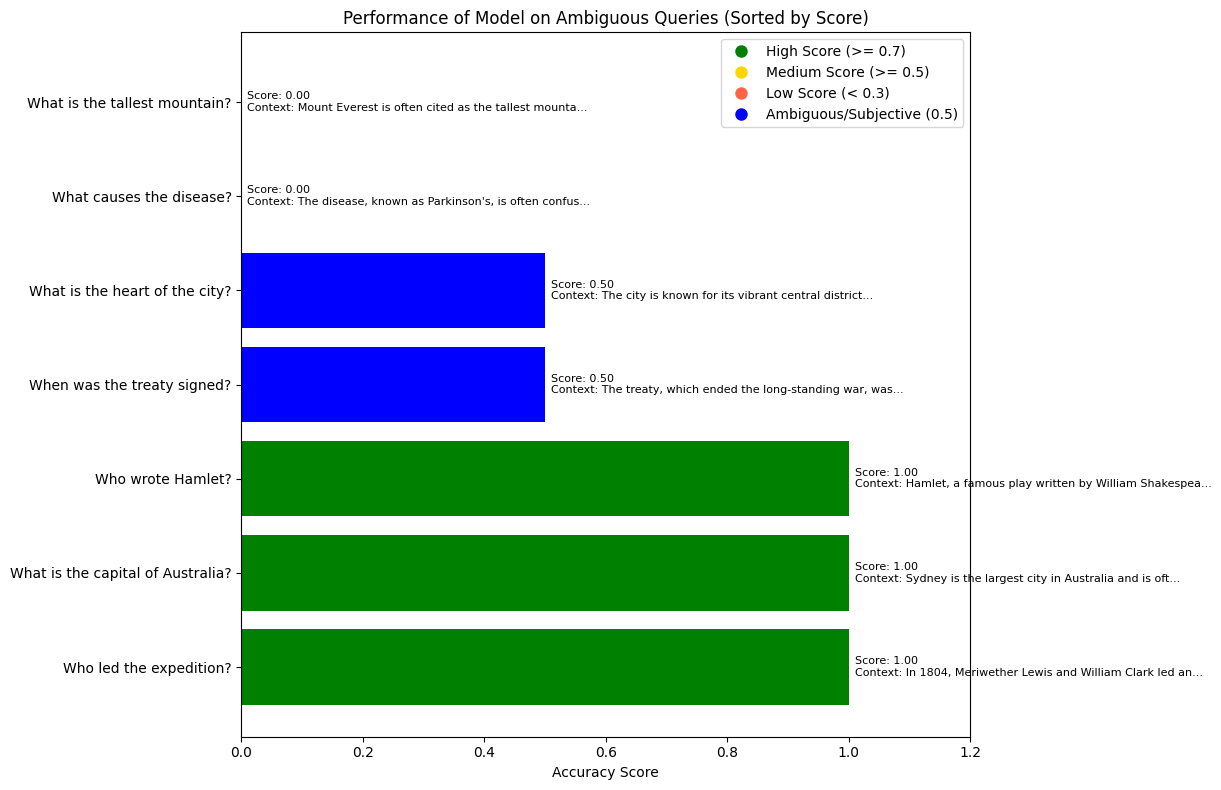

In [81]:
query_score_pairs = list(zip(ambiguous_queries, performance_scores))

# Sort the pairs in decreasing order of score
sorted_pairs = sorted(query_score_pairs, key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs
sorted_queries, sorted_scores = zip(*sorted_pairs)

# Define colors based on performance score (green for high, blue for medium, tomato for low, gold for ambiguous)
colors = np.where(np.array(sorted_scores) >= 0.7, 'green', np.where(np.array(sorted_scores) >= 0.5, 'blue', np.where(np.array(sorted_scores) >= 0.3, 'tomato', 'gold')))

plt.figure(figsize=(12, 8))  # Adjust size for better visibility
bars = plt.barh(sorted_queries, sorted_scores, color=colors)

# Annotating each bar with the corresponding context and performance score
for index, (query, score) in enumerate(zip(sorted_queries, sorted_scores)):
    context_index = ambiguous_queries.index(query)  # Find the original index of the query to get the correct context
    context = contexts[context_index]
    plt.text(score + 0.01, index, f'Score: {score:.2f}\nContext: {context[:50]}...', fontsize=8, va='center')

plt.xlabel('Accuracy Score')
plt.title('Performance of Model on Ambiguous Queries (Sorted by Score)')
plt.xlim(0, 1.2)  # Extend xlim to make room for annotations

# Customize the legend for performance score colors
legend_labels = ['High Score (>= 0.7)', 'Medium Score (>= 0.5)', 'Low Score (< 0.3)', 'Ambiguous/Subjective (0.5)']
legend_colors = ['green', 'gold', 'tomato', 'blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, loc='upper right')

plt.tight_layout()  # Adjust layout to fit everything
plt.show()
